In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import numba
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pathlib
import rioxarray as rxr
import seaborn as sns
from sklearn.model_selection import KFold
import statsmodels.formula.api as smf
import skgstat as skg
from tqdm.autonotebook import tqdm
from typing import List

import holoviews as hv
import hvplot.pandas        # Necessary for calling .hvplot on a geodatafame

HANSEN_PATH = pathlib.Path('/home/forecol/data/Hansen/')

In [2]:
df = pd.read_feather('/home/forecol/data/Overlays/GEDI4A_JRC_filtering/dfs_all.feather')

In [3]:
l4a_data = df
l4a_data['agcd'] = l4a_data.agbd * 0.48
quality_gedi = l4a_data[
    (l4a_data.overlap_quality > 1) & 
    (l4a_data.overlap_quality != 3) &
    (l4a_data.recovery_period >= 3) & 
    (l4a_data.recovery_period <= 22) & 
    (l4a_data.l4_quality_flag == 1) & 
    (l4a_data.l2_quality_flag == 1) &
    (l4a_data.degrade_flag == 0) #&
    #(l4a_data.agcd > 0.5)
] 
print(len(quality_gedi))

96348


In [4]:
@numba.njit
def argnearest_centers(array, values):
    half_pixel = (array[1] - array[0]) / 2
    array_center = array + half_pixel
    argmins = np.zeros_like(values, dtype=np.int64)
    for i, value in enumerate(values):
        argmins[i] = (np.abs(array_center - value)).argmin()
    return argmins

def get_inrange(df, tile):
    xmin = tile.x.data.min()
    xmax = tile.x.data.max()
    ymin = tile.y.data.min()
    ymax = tile.y.data.max()

    return (df.lon_lowestmode > xmin) & (df.lon_lowestmode < xmax) & (df.lat_lowestmode > ymin) & (df.lat_lowestmode < ymax)
    

In [5]:
tiles = (HANSEN_PATH / 'gain').glob('*.tif')
quality_gedi['gain'] = -1

for tile_name in tqdm(tiles):
    tile = rxr.open_rasterio(tile_name)
    inrange = get_inrange(quality_gedi, tile)
    x_inds = argnearest_centers(tile.x.data, quality_gedi[inrange].lon_lowestmode.values)
    y_inds = argnearest_centers(tile.y.data, quality_gedi[inrange].lon_lowestmode.values)
    quality_gedi.loc[inrange,'gain'] = tile.data[0][y_inds, x_inds]


/tmp/ipykernel_1518302/2317396314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quality_gedi['gain'] = -1


0it [00:00, ?it/s]

/home/forecol/bin/miniconda3/envs/biomass/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/forecol/bin/miniconda3/envs/biomass/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/forecol/bin/miniconda3/envs/biomass/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning

In [10]:
tiles = (HANSEN_PATH / 'lossyear').glob('*.tif')
quality_gedi['lossyear'] = -1

for tile_name in tqdm(tiles):
    tile = rxr.open_rasterio(tile_name)
    inrange = get_inrange(quality_gedi, tile)
    x_inds = argnearest_centers(tile.x.data, quality_gedi[inrange].lon_lowestmode.values)
    y_inds = argnearest_centers(tile.y.data, quality_gedi[inrange].lon_lowestmode.values)
    quality_gedi.loc[inrange,'lossyear'] = tile.data[0][y_inds, x_inds]

/tmp/ipykernel_1518302/2909619259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quality_gedi['lossyear'] = -1


0it [00:00, ?it/s]

/home/forecol/bin/miniconda3/envs/biomass/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/forecol/bin/miniconda3/envs/biomass/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/forecol/bin/miniconda3/envs/biomass/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning

In [11]:
quality_gedi

,shot_number,recovery_period,overlap_quality,lon_lowestmode,lat_lowestmode,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,l2_quality_flag,l4_quality_flag,degrade_flag,agcd,gain,lossyear
93,90220118800510404,8.0,2,-52.015377,-3.536172,60.930367,3.432684,189.305435,13.091489,1,1,0,29.246576,0,0
101,69100023600094450,11.0,5,-52.031741,-3.483854,66.069481,4.730172,198.295135,13.093150,1,1,0,31.713351,0,0
177,74590823900094056,15.0,4,-52.265532,-3.248065,2.661009,-9999.000000,57.577579,13.107719,1,1,0,1.277284,0,6
180,74590800300094059,15.0,2,-52.264638,-3.246806,65.590141,4.598710,197.489273,13.097090,1,1,0,31.483268,0,6
226,69101121100093221,8.0,2,-52.012388,-3.525156,0.998087,-9999.000000,48.400158,13.113224,1,1,0,0.479082,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2198265,57440802000516482,3.0,2,-77.031162,-6.119297,70.139755,5.866429,205.286575,13.090769,1,1,0,33.667083,0,0
2198371,35000317800251513,13.0,2,-63.030015,-6.821400,46.935844,0.803456,163.983170,13.098426,1,1,0,22.529205,0,0
2198372,35000318000251514,13.0,2,-63.029713,-6.821820,24.561174,-9999.000000,119.028931,13.096219,1,1,0,11.789364,0,0
2198374,35000811100256668,16.0,2,-63.043693,-6.839033,109.962021,20.559408,270.217926,13.087045,1,1,0,52.781770,0,0


In [46]:
# Additional filtering according to the following rules.
# 1. If forest cover gain == 1,
#       then recovery period must be between 8-20 years
rule_1 = ((quality_gedi.gain == 1) & (quality_gedi.recovery_period <= 20) & (quality_gedi.recovery_period >= 8)) | (quality_gedi.gain != 1)
fails_rule_1 = quality_gedi[~rule_1]
# 2. If forest cover gain == 0,
#       then recovery period must be >= 20 or <= 8 years
rule_2 = ((quality_gedi.gain == 0) & ((quality_gedi.recovery_period >= 20) | (quality_gedi.recovery_period <= 8))) | (quality_gedi.gain != 0)
fails_rule_2 = quality_gedi[~rule_2]

# 3. If forest cover loss year != 0,
#       then recovery period must be <= loss year
rule_3 = ((quality_gedi.lossyear != 0) & (quality_gedi.recovery_period <= quality_gedi.lossyear)) | (quality_gedi.lossyear == 0)
fails_rule_3 = quality_gedi[~rule_3]

# 4. If forest cover loss year == 0,
#       then recovery period must be > 17 or < 3
rule_4 = ((quality_gedi.lossyear == 0) & ((quality_gedi.recovery_period >= 17) | (quality_gedi.recovery_period < 3))) | (quality_gedi.lossyear != 0)
fails_rule_4 = quality_gedi[~rule_4]

In [61]:
print(fails_rule_2[['recovery_period' ,'gain']])
print(len(quality_gedi[quality_gedi.gain == 1]))
print(len(quality_gedi[quality_gedi.lossyear == 0]))

         recovery_period  gain
101                 11.0     0
177                 15.0     0
180                 15.0     0
679                 11.0     0
824                 11.0     0
...                  ...   ...
2197722             12.0     0
2198371             13.0     0
2198372             13.0     0
2198374             16.0     0
2198391             16.0     0

[31498 rows x 2 columns]
373
87447


In [48]:
print(len(fails_rule_1))
print(len(fails_rule_2))
print(len(fails_rule_3))
print(len(fails_rule_4))

159
31498
3698
81101


In [59]:
hansen_agrees = quality_gedi[(rule_1 & rule_3)]
len(hansen_agrees)

92515

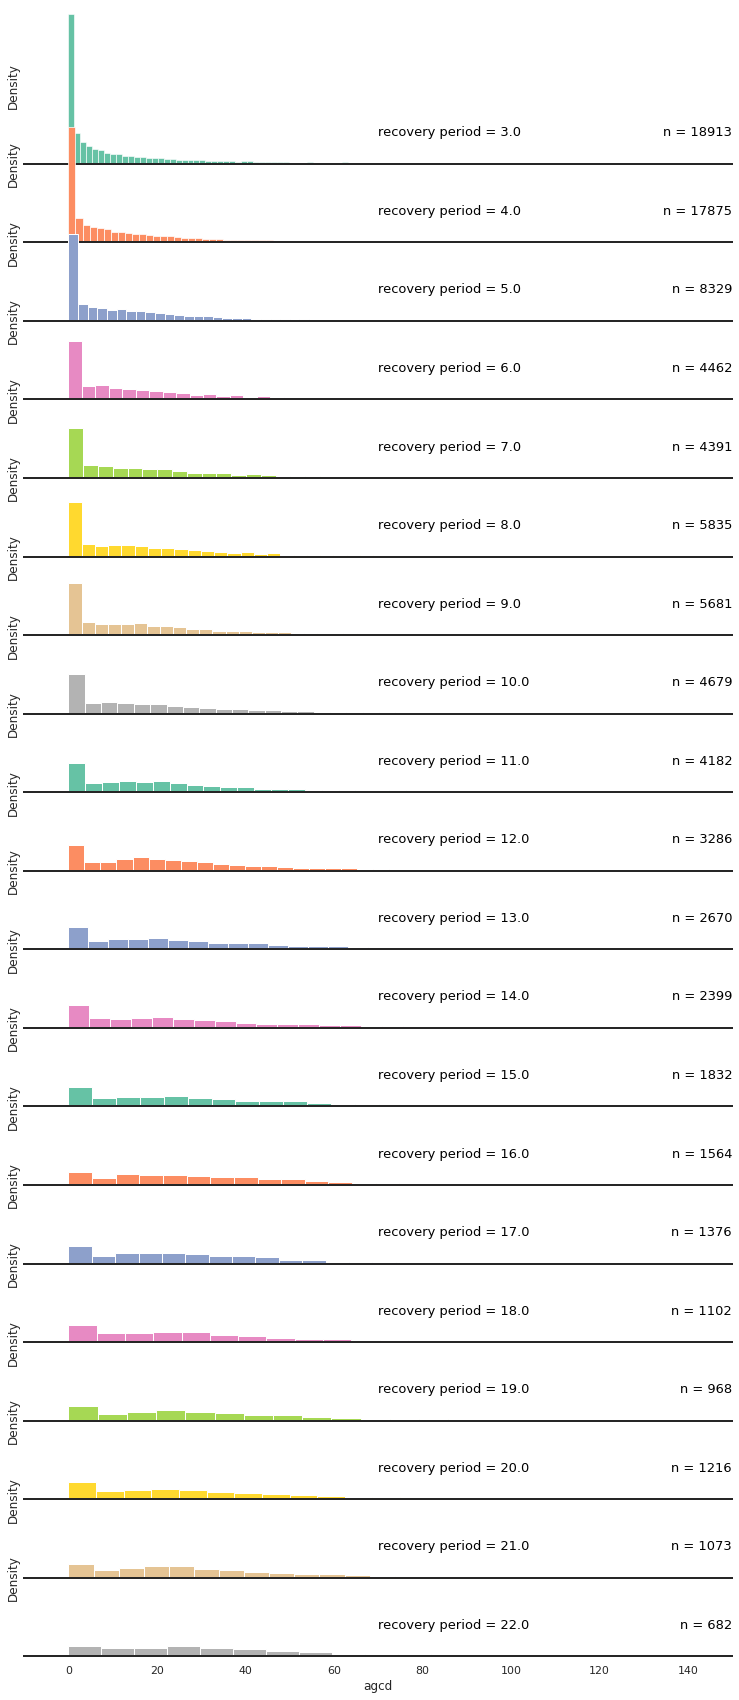

In [60]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(hansen_agrees, palette=palette, row="recovery_period", hue="recovery_period", aspect=9, height=1.2, xlim=[-10,150])
g.map_dataframe(sns.histplot, x="agcd", fill=True, alpha=1, stat='density')
#g.map_dataframe(sns.kdeplot, x="agcd", color='black')


def label(x, color, label):
    ax = plt.gca()
    ax.text(0.5, .2, f'recovery period = {label}', color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    ax.text(1, .2, f'n = {len(x)}', color='black', fontsize=13,
            ha='right', va='center', transform=ax.transAxes)
    
g.map(label, "recovery_period")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="agcd")
g.despine( left=True)